In [7]:
using Sundials

type FAndP
    f::Function
    p::Vector{Float64}
end

function unzip(fp::Ptr{Void})
    fp = unsafe_pointer_to_objref(f_and_p) :: FAndP
    (fp.f, fp.p)
end

function cvodesfun(t, y, ydot, fp)
    y    = Sundials.asarray(y)
    ydot = Sundials.asarray(ydot)
    f,p = unzip(fp)
    f(t, y, ydot, p)
    return Int32(0)
end

# using the function f(t) = a*sin(b*t), f(0) = 0, we create an ODE by differentiating .

function cvodes(f::Function, y0::Vector{Float64}, p::Vector{Float64}, ts::Vector{Float64}; reltol=1e-8, abstol=1e-6)
  ydot = zeros(y0)
  neq  = length(y0)
  np = length(p)
  
  ### CVode settings ###
    
  cvode_mem = Sundials.CVodeCreate(Sundials.CV_BDF, Sundials.CV_NEWTON)
  flag = Sundials.CVodeInit(cvode_mem, cvodesfun, t[1], y0)
  flag = Sundials.CVodeSetUserData(cvode_mem, FAndP(f,p))
  flag = Sundials.CVodeSStolerances(cvode_mem, reltol, abstol)
  flag = Sundials.CVDense(cvode_mem, neq)
  
  ### Sensiviy Settings ###
  
  yS = [Sundials.nvector(zeros(Float64, neq)) for i in 1:np] |> pointer  
    
  flag = Sundials.CVodeSensInit1(cvode_mem, np, Sundials.CV_SIMULTANEOUS, Ptr{Void}(0), yS);
  flag = Sundials.CVodeSensEEtolerances(cvode_mem);
  flag = Sundials.CVodeSetSensErrCon(cvode_mem, 0);
  #flag = Sundials.CVodeSensSStolerances(cvode_mem, reltol, sens_tol_vec);
  flag = Sundials.CVodeSetSensDQMethod(cvode_mem, Sundials.CV_CENTERED, 0.0);
  flag = Sundials.CVodeSetSensParams(cvode_mem, p, p, Ptr{Int32}(0));


  # Placeholder for solution and sensitivities
  solution = zeros(length(t), neq)
  solution[1,:] = copy(y0)
  sens = zeros(length(t),neq,np) # No need to copy initial condition, they are already zero

  tout = [t[1]] # output time reached by the solver
  yout = copy(y0)

  # Loop through all the output times
  for k in 2:length(t)
    # Extract the solution to x, and the sensitivities to yS
    flag = Sundials.CVode(cvode_mem, t[k], yout, tout, Sundials.CV_NORMAL)
    flag = Sundials.CVodeGetSens(cvode_mem, tout, yS)

    #Save the results
    solution[k,:] = yout
    for i in 1:np
      sens[k,:,i] = Sundials.asarray(unsafe_load(yS,i))
    end
  end

  return (solution,sens)
end

cvodes (generic function with 1 method)

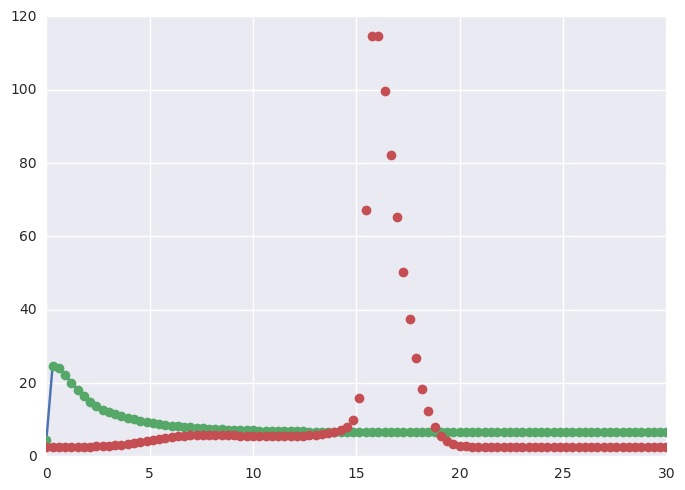

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f423c9bbbd0>

4.588680 seconds (37.30 M allocations: 771.930 MB, 11.23% gc time)
  0.017436 seconds (137.00 k allocations: 2.837 MB)
  0.041812 seconds (7 allocations: 26.391 KB)


In [374]:
using PyPlot
using GynC
include("../src/gyncycle.jl")

t = collect(linspace(0,30,100));
p = GynC.refallparms
y0 = GynC.refy0

@time (sol_cvodes, sens) = cvodes((t, y, ydot, p) -> gyncycle_rhs!(y, p, ydot), y0, p, t)
@time sol_cvode = Sundials.cvode((t,y,ydot) -> gyncycle_rhs!(y, p, ydot), y0, t)
@time sol_limex = GynC.gync(y0, t, p)


plot(t, sol_cvodes[:,7])
plot(t, sol_cvode[:,7], "o")
plot(t, sol_limex[2,:] |> vec, "o")